In [214]:
import pandas as pd
import numpy as np
import os
import datetime
import sys
import bisect

sys.path.insert(0, '..')

from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

In [215]:
import umap
import umap.plot

In [216]:
raw_df = pd.read_hdf("../data/processed/summaries_terran.hdf", "summaries")
raw_df = raw_df[raw_df.game_duration > 280]
raw_df.head()

,game_start,game_duration,self_won,self_name,self_race_is_protoss,self_race_is_zerg,self_race_is_terran,opponent_name,opponent_race_is_protoss,opponent_race_is_zerg,...,ToOrbitalCommand_start,ToOrbitalCommand_weight,VehicleWeapons1_start,VehicleWeapons1_weight,Viking_start,Viking_weight,WeaponRefit_start,WeaponRefit_weight,WidowMine_start,WidowMine_weight
045eeb4f0df4c471d53c4f1db5eea0294279e0d69fad7af2c2624e914806a2ba_0,2020-02-02 14:59:40,318,0.0,DPGCure,0.0,0.0,1.0,Ragnarok,0.0,1.0,...,11.045361,1.823720,1000.0,0.0,17.291616,1.000000,1000.0,0.0,1000.000000,0.000000
50cb3b2f33692227e2e50e0e4fab529a44c4bfe9bfd9e8137c08a81e94f08370_0,2020-02-02 12:13:08,886,1.0,cure,0.0,0.0,1.0,ShoWTimE,1.0,0.0,...,11.045361,1.505857,1000.0,0.0,1000.000000,0.000000,1000.0,0.0,1000.000000,0.000000
2dec4bc09dd0bc7ddce46647f9357ad305081163ab605141e4a1bfcb676e03ba_1,2020-02-02 14:18:11,744,0.0,DPGCure,0.0,0.0,1.0,Ragnarok,0.0,1.0,...,11.090537,1.645843,1000.0,0.0,1000.000000,0.000000,1000.0,0.0,1000.000000,0.000000
038ca41ecf0198facf7425bfd5cfa9237f144e4e41d9c556b204612d55088de1_0,2020-02-02 13:34:45,825,1.0,cure,0.0,0.0,1.0,ShoWTimE,1.0,0.0,...,11.045361,1.606104,1000.0,0.0,1000.000000,0.000000,1000.0,0.0,17.916473,4.607736
55d158aa1beca63ed10d50cfe9f29715330bc5ba44e12cae5625b7a4b959965c_1,2020-02-02 12:29:36,1400,0.0,cure,0.0,0.0,1.0,ShoWTimE,1.0,0.0,...,11.269428,1.578888,1000.0,0.0,20.469489,2.620315,1000.0,0.0,1000.000000,0.000000


In [217]:
metadata_columns = """
self_won
game_start
game_duration
self_name self_race_is_protoss self_race_is_zerg self_race_is_terran
opponent_name
""".split()
weight_columns = [col for col in raw_df.columns if col.endswith("_weight")]

data_columns = [col for col in raw_df.columns if col not in metadata_columns and col not in weight_columns]

df = raw_df[data_columns]

encoding_dim = 5

In [218]:
#df.sort_values('DarkTemplar_start').tail(10)



In [219]:
input_data = Input(shape=(len(df.columns),))

encoded = Dense(64, activation='relu')(input_data)
encoded = Dense(24, activation='relu')(input_data)
#encoded = Dense(24, activation='relu')(input_data)

encoded = Dense(encoding_dim, activation='relu',
                    activity_regularizer=regularizers.l1(10e-3))(encoded)


#decoded = Dense(24, activation='relu')(encoded)
decoded = Dense(24, activation='relu')(encoded)
decoded = Dense(64, activation='relu')(decoded)
decoded = Dense(len(df.columns), activation='linear')(decoded)

autoencoder = Model(input_data, decoded)


In [220]:
encoder = Model(input_data, encoded)

In [221]:
autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')

In [222]:
x_all = df.sample(frac=1.0).values
num_samples = int(0.9 * x_all.shape[0])
x_train, x_test = x_all[:num_samples, :], x_all[num_samples:, :]
print("Training on {} samples. Testing on {}.".format(
    num_samples, x_all.shape[0] - num_samples))


Training on 2455 samples. Testing on 273.


In [223]:
autoencoder.fit(x_train, x_train,
                epochs=2500,
                batch_size=512,
                shuffle=True,
                validation_data=(x_test, x_test))


Train on 2455 samples, validate on 273 samples
Epoch 1/2500
2455/2455 [==============================] - 0s 65us/step - loss: 634073.8487 - val_loss: 611993.6875
Epoch 2/2500
2455/2455 [==============================] - 0s 9us/step - loss: 594118.7629 - val_loss: 471204.4688
Epoch 3/2500
2455/2455 [==============================] - 0s 9us/step - loss: 280490.2280 - val_loss: 104381.4062
Epoch 4/2500
2455/2455 [==============================] - 0s 12us/step - loss: 118494.8042 - val_loss: 120205.4531
Epoch 5/2500
2455/2455 [==============================] - 0s 8us/step - loss: 119499.1970 - val_loss: 103117.4609
Epoch 6/2500
2455/2455 [==============================] - 0s 10us/step - loss: 113104.4356 - val_loss: 105790.7500
Epoch 7/2500
2455/2455 [==============================] - 0s 10us/step - loss: 108946.2563 - val_loss: 97737.8594
Epoch 8/2500
2455/2455 [==============================] - 0s 11us/step - loss: 104598.5734 - val_loss: 96405.6875
Epoch 9/2500
2455/2455 [==============

2455/2455 [==============================] - 0s 10us/step - loss: 81398.6081 - val_loss: 78133.9375
Epoch 73/2500
2455/2455 [==============================] - 0s 9us/step - loss: 81555.5458 - val_loss: 76494.8281
Epoch 74/2500
2455/2455 [==============================] - 0s 9us/step - loss: 81873.3205 - val_loss: 78820.5547
Epoch 75/2500
2455/2455 [==============================] - 0s 8us/step - loss: 81511.9272 - val_loss: 75261.5625
Epoch 76/2500
2455/2455 [==============================] - 0s 9us/step - loss: 80982.5371 - val_loss: 78103.2031
Epoch 77/2500
2455/2455 [==============================] - 0s 9us/step - loss: 81636.9014 - val_loss: 75408.9375
Epoch 78/2500
2455/2455 [==============================] - 0s 9us/step - loss: 80564.9500 - val_loss: 76889.5000
Epoch 79/2500
2455/2455 [==============================] - 0s 8us/step - loss: 80798.8294 - val_loss: 76325.0703
Epoch 80/2500
2455/2455 [==============================] - 0s 8us/step - loss: 81797.4448 - val_loss: 77469.9

2455/2455 [==============================] - 0s 6us/step - loss: 74806.3089 - val_loss: 72988.6406
Epoch 145/2500
2455/2455 [==============================] - 0s 8us/step - loss: 73976.6554 - val_loss: 67052.5938
Epoch 146/2500
2455/2455 [==============================] - 0s 7us/step - loss: 69616.8046 - val_loss: 68196.3203
Epoch 147/2500
2455/2455 [==============================] - 0s 6us/step - loss: 70104.1494 - val_loss: 62427.1133
Epoch 148/2500
2455/2455 [==============================] - 0s 6us/step - loss: 65140.9702 - val_loss: 66415.0312
Epoch 149/2500
2455/2455 [==============================] - 0s 6us/step - loss: 69017.5012 - val_loss: 64236.6211
Epoch 150/2500
2455/2455 [==============================] - 0s 6us/step - loss: 68887.7763 - val_loss: 68369.5234
Epoch 151/2500
2455/2455 [==============================] - 0s 6us/step - loss: 72530.6250 - val_loss: 66258.2500
Epoch 152/2500
2455/2455 [==============================] - 0s 6us/step - loss: 71216.7126 - val_loss: 

Epoch 216/2500
2455/2455 [==============================] - 0s 9us/step - loss: 61597.2190 - val_loss: 60113.4297
Epoch 217/2500
2455/2455 [==============================] - 0s 9us/step - loss: 60919.0510 - val_loss: 58784.3398
Epoch 218/2500
2455/2455 [==============================] - 0s 10us/step - loss: 62061.1300 - val_loss: 62085.2734
Epoch 219/2500
2455/2455 [==============================] - 0s 10us/step - loss: 66900.7804 - val_loss: 68099.0156
Epoch 220/2500
2455/2455 [==============================] - 0s 8us/step - loss: 66465.2729 - val_loss: 61042.8789
Epoch 221/2500
2455/2455 [==============================] - 0s 8us/step - loss: 64466.8211 - val_loss: 63695.8359
Epoch 222/2500
2455/2455 [==============================] - 0s 9us/step - loss: 65006.6129 - val_loss: 63820.1680
Epoch 223/2500
2455/2455 [==============================] - 0s 7us/step - loss: 64380.2928 - val_loss: 58267.3984
Epoch 224/2500
2455/2455 [==============================] - 0s 6us/step - loss: 62579.

2455/2455 [==============================] - 0s 7us/step - loss: 60449.0412 - val_loss: 61046.7148
Epoch 288/2500
2455/2455 [==============================] - 0s 8us/step - loss: 63162.0850 - val_loss: 57743.6836
Epoch 289/2500
2455/2455 [==============================] - 0s 7us/step - loss: 61071.1610 - val_loss: 59574.9375
Epoch 290/2500
2455/2455 [==============================] - 0s 7us/step - loss: 59985.7362 - val_loss: 56101.9141
Epoch 291/2500
2455/2455 [==============================] - 0s 7us/step - loss: 59379.3484 - val_loss: 58892.8516
Epoch 292/2500
2455/2455 [==============================] - 0s 7us/step - loss: 61256.7351 - val_loss: 57694.3789
Epoch 293/2500
2455/2455 [==============================] - 0s 7us/step - loss: 62201.7693 - val_loss: 59533.1133
Epoch 294/2500
2455/2455 [==============================] - 0s 6us/step - loss: 59862.7287 - val_loss: 55284.7500
Epoch 295/2500
2455/2455 [==============================] - 0s 7us/step - loss: 57863.8528 - val_loss: 

Epoch 359/2500
2455/2455 [==============================] - 0s 7us/step - loss: 58262.7714 - val_loss: 54924.3086
Epoch 360/2500
2455/2455 [==============================] - 0s 7us/step - loss: 57679.8346 - val_loss: 55893.2812
Epoch 361/2500
2455/2455 [==============================] - 0s 6us/step - loss: 57361.6053 - val_loss: 53897.7344
Epoch 362/2500
2455/2455 [==============================] - 0s 6us/step - loss: 56456.8890 - val_loss: 55586.0898
Epoch 363/2500
2455/2455 [==============================] - 0s 7us/step - loss: 57399.2958 - val_loss: 54703.1875
Epoch 364/2500
2455/2455 [==============================] - 0s 7us/step - loss: 56692.2730 - val_loss: 54201.8906
Epoch 365/2500
2455/2455 [==============================] - 0s 7us/step - loss: 56673.7625 - val_loss: 54720.0625
Epoch 366/2500
2455/2455 [==============================] - 0s 7us/step - loss: 56854.8217 - val_loss: 55101.0977
Epoch 367/2500
2455/2455 [==============================] - 0s 7us/step - loss: 56485.55

Epoch 431/2500
2455/2455 [==============================] - 0s 8us/step - loss: 54170.8341 - val_loss: 54224.2031
Epoch 432/2500
2455/2455 [==============================] - 0s 7us/step - loss: 55176.8141 - val_loss: 53439.4453
Epoch 433/2500
2455/2455 [==============================] - 0s 7us/step - loss: 56450.2232 - val_loss: 56420.0625
Epoch 434/2500
2455/2455 [==============================] - 0s 7us/step - loss: 56090.7675 - val_loss: 53726.8164
Epoch 435/2500
2455/2455 [==============================] - 0s 6us/step - loss: 55401.7612 - val_loss: 54601.9844
Epoch 436/2500
2455/2455 [==============================] - 0s 6us/step - loss: 54829.8915 - val_loss: 52432.5781
Epoch 437/2500
2455/2455 [==============================] - 0s 6us/step - loss: 54376.8895 - val_loss: 53287.1367
Epoch 438/2500
2455/2455 [==============================] - 0s 6us/step - loss: 54864.6190 - val_loss: 54335.6914
Epoch 439/2500
2455/2455 [==============================] - 0s 6us/step - loss: 55070.35

Epoch 503/2500
2455/2455 [==============================] - 0s 7us/step - loss: 52708.3062 - val_loss: 54451.2070
Epoch 504/2500
2455/2455 [==============================] - 0s 7us/step - loss: 54412.6183 - val_loss: 52255.0078
Epoch 505/2500
2455/2455 [==============================] - 0s 7us/step - loss: 53345.6305 - val_loss: 53588.0352
Epoch 506/2500
2455/2455 [==============================] - 0s 7us/step - loss: 52732.7291 - val_loss: 51166.8398
Epoch 507/2500
2455/2455 [==============================] - 0s 6us/step - loss: 52024.9439 - val_loss: 51987.1875
Epoch 508/2500
2455/2455 [==============================] - 0s 7us/step - loss: 50795.7070 - val_loss: 49676.2227
Epoch 509/2500
2455/2455 [==============================] - 0s 7us/step - loss: 50628.5757 - val_loss: 51680.6953
Epoch 510/2500
2455/2455 [==============================] - 0s 7us/step - loss: 52093.2187 - val_loss: 51441.5469
Epoch 511/2500
2455/2455 [==============================] - 0s 7us/step - loss: 52651.49

Epoch 575/2500
2455/2455 [==============================] - 0s 9us/step - loss: 49947.7396 - val_loss: 49696.7695
Epoch 576/2500
2455/2455 [==============================] - 0s 9us/step - loss: 48725.2655 - val_loss: 48068.0898
Epoch 577/2500
2455/2455 [==============================] - 0s 9us/step - loss: 47646.9326 - val_loss: 47452.4375
Epoch 578/2500
2455/2455 [==============================] - 0s 8us/step - loss: 47318.0696 - val_loss: 47728.6641
Epoch 579/2500
2455/2455 [==============================] - 0s 7us/step - loss: 47431.0986 - val_loss: 47768.3477
Epoch 580/2500
2455/2455 [==============================] - 0s 7us/step - loss: 48965.1759 - val_loss: 51574.3203
Epoch 581/2500
2455/2455 [==============================] - 0s 8us/step - loss: 50048.2701 - val_loss: 48934.8555
Epoch 582/2500
2455/2455 [==============================] - 0s 8us/step - loss: 49800.7320 - val_loss: 51500.6250
Epoch 583/2500
2455/2455 [==============================] - 0s 9us/step - loss: 49931.19

2455/2455 [==============================] - 0s 6us/step - loss: 47361.3590 - val_loss: 47219.1289
Epoch 647/2500
2455/2455 [==============================] - 0s 6us/step - loss: 47140.8681 - val_loss: 46574.8789
Epoch 648/2500
2455/2455 [==============================] - 0s 7us/step - loss: 46396.9465 - val_loss: 47816.3398
Epoch 649/2500
2455/2455 [==============================] - 0s 7us/step - loss: 47244.7285 - val_loss: 48020.1953
Epoch 650/2500
2455/2455 [==============================] - 0s 10us/step - loss: 48341.4274 - val_loss: 50389.4922
Epoch 651/2500
2455/2455 [==============================] - 0s 8us/step - loss: 48989.0966 - val_loss: 48521.9219
Epoch 652/2500
2455/2455 [==============================] - 0s 7us/step - loss: 48596.4236 - val_loss: 49849.7734
Epoch 653/2500
2455/2455 [==============================] - 0s 7us/step - loss: 48746.7500 - val_loss: 47628.3398
Epoch 654/2500
2455/2455 [==============================] - 0s 6us/step - loss: 48674.2096 - val_loss:

2455/2455 [==============================] - 0s 6us/step - loss: 46383.3743 - val_loss: 46521.3477
Epoch 718/2500
2455/2455 [==============================] - 0s 6us/step - loss: 45947.5995 - val_loss: 45315.4219
Epoch 719/2500
2455/2455 [==============================] - 0s 6us/step - loss: 44910.0149 - val_loss: 45843.6992
Epoch 720/2500
2455/2455 [==============================] - 0s 7us/step - loss: 45207.2448 - val_loss: 45518.7070
Epoch 721/2500
2455/2455 [==============================] - 0s 7us/step - loss: 45644.5530 - val_loss: 47401.7930
Epoch 722/2500
2455/2455 [==============================] - 0s 8us/step - loss: 46637.5175 - val_loss: 46659.0039
Epoch 723/2500
2455/2455 [==============================] - 0s 9us/step - loss: 46560.1366 - val_loss: 48396.1797
Epoch 724/2500
2455/2455 [==============================] - 0s 7us/step - loss: 46974.4819 - val_loss: 47124.7500
Epoch 725/2500
2455/2455 [==============================] - 0s 7us/step - loss: 47187.0764 - val_loss: 

Epoch 789/2500
2455/2455 [==============================] - 0s 6us/step - loss: 44906.6799 - val_loss: 45063.9961
Epoch 790/2500
2455/2455 [==============================] - 0s 7us/step - loss: 44391.8808 - val_loss: 46310.2891
Epoch 791/2500
2455/2455 [==============================] - 0s 8us/step - loss: 45696.9519 - val_loss: 46624.1133
Epoch 792/2500
2455/2455 [==============================] - 0s 7us/step - loss: 45447.6634 - val_loss: 44913.5156
Epoch 793/2500
2455/2455 [==============================] - 0s 7us/step - loss: 44849.9473 - val_loss: 47112.4414
Epoch 794/2500
2455/2455 [==============================] - 0s 7us/step - loss: 45264.0067 - val_loss: 45058.8047
Epoch 795/2500
2455/2455 [==============================] - 0s 7us/step - loss: 45133.5186 - val_loss: 46091.0039
Epoch 796/2500
2455/2455 [==============================] - 0s 7us/step - loss: 45205.4401 - val_loss: 45543.1523
Epoch 797/2500
2455/2455 [==============================] - 0s 7us/step - loss: 46128.02

2455/2455 [==============================] - 0s 8us/step - loss: 44797.6620 - val_loss: 45708.4258
Epoch 861/2500
2455/2455 [==============================] - 0s 7us/step - loss: 44955.6346 - val_loss: 44067.7422
Epoch 862/2500
2455/2455 [==============================] - 0s 6us/step - loss: 44167.8262 - val_loss: 44203.2539
Epoch 863/2500
2455/2455 [==============================] - 0s 6us/step - loss: 43384.3102 - val_loss: 43036.2461
Epoch 864/2500
2455/2455 [==============================] - 0s 6us/step - loss: 43416.8274 - val_loss: 44809.1445
Epoch 865/2500
2455/2455 [==============================] - 0s 8us/step - loss: 44002.5983 - val_loss: 43795.1172
Epoch 866/2500
2455/2455 [==============================] - 0s 8us/step - loss: 44205.2760 - val_loss: 45965.7852
Epoch 867/2500
2455/2455 [==============================] - 0s 7us/step - loss: 45223.9144 - val_loss: 45058.0312
Epoch 868/2500
2455/2455 [==============================] - 0s 8us/step - loss: 44567.7356 - val_loss: 

Epoch 932/2500
2455/2455 [==============================] - 0s 6us/step - loss: 43909.5645 - val_loss: 43714.0977
Epoch 933/2500
2455/2455 [==============================] - 0s 6us/step - loss: 42367.4846 - val_loss: 43154.0820
Epoch 934/2500
2455/2455 [==============================] - 0s 7us/step - loss: 43547.1963 - val_loss: 46465.7578
Epoch 935/2500
2455/2455 [==============================] - 0s 8us/step - loss: 44497.1356 - val_loss: 43345.3789
Epoch 936/2500
2455/2455 [==============================] - 0s 8us/step - loss: 43069.2023 - val_loss: 43829.3242
Epoch 937/2500
2455/2455 [==============================] - 0s 8us/step - loss: 43608.5280 - val_loss: 44717.0625
Epoch 938/2500
2455/2455 [==============================] - 0s 6us/step - loss: 44662.1554 - val_loss: 45793.5938
Epoch 939/2500
2455/2455 [==============================] - 0s 8us/step - loss: 44675.4071 - val_loss: 43935.8320
Epoch 940/2500
2455/2455 [==============================] - 0s 8us/step - loss: 44423.93

2455/2455 [==============================] - 0s 6us/step - loss: 43410.3830 - val_loss: 45061.8672
Epoch 1004/2500
2455/2455 [==============================] - 0s 7us/step - loss: 43693.4990 - val_loss: 43529.4453
Epoch 1005/2500
2455/2455 [==============================] - 0s 6us/step - loss: 43502.9517 - val_loss: 44645.6680
Epoch 1006/2500
2455/2455 [==============================] - 0s 7us/step - loss: 43844.3713 - val_loss: 43550.8203
Epoch 1007/2500
2455/2455 [==============================] - 0s 7us/step - loss: 43144.8941 - val_loss: 43990.3828
Epoch 1008/2500
2455/2455 [==============================] - 0s 7us/step - loss: 42283.6669 - val_loss: 41791.1602
Epoch 1009/2500
2455/2455 [==============================] - 0s 6us/step - loss: 41911.0338 - val_loss: 41695.3945
Epoch 1010/2500
2455/2455 [==============================] - 0s 6us/step - loss: 40499.1748 - val_loss: 40838.0117
Epoch 1011/2500
2455/2455 [==============================] - ETA: 0s - loss: 40003.691 - 0s 7us/

Epoch 1074/2500
2455/2455 [==============================] - 0s 8us/step - loss: 41729.7106 - val_loss: 42016.4336
Epoch 1075/2500
2455/2455 [==============================] - 0s 9us/step - loss: 42048.7235 - val_loss: 43006.1367
Epoch 1076/2500
2455/2455 [==============================] - 0s 7us/step - loss: 42286.9677 - val_loss: 41973.4688
Epoch 1077/2500
2455/2455 [==============================] - 0s 7us/step - loss: 42206.4893 - val_loss: 43900.9648
Epoch 1078/2500
2455/2455 [==============================] - 0s 7us/step - loss: 42734.6812 - val_loss: 42172.6914
Epoch 1079/2500
2455/2455 [==============================] - 0s 8us/step - loss: 42386.9907 - val_loss: 43623.4258
Epoch 1080/2500
2455/2455 [==============================] - 0s 7us/step - loss: 42354.1558 - val_loss: 42432.0156
Epoch 1081/2500
2455/2455 [==============================] - 0s 7us/step - loss: 42915.2204 - val_loss: 45238.8594
Epoch 1082/2500
2455/2455 [==============================] - 0s 8us/step - loss:

2455/2455 [==============================] - 0s 6us/step - loss: 42640.7243 - val_loss: 42677.7812
Epoch 1146/2500
2455/2455 [==============================] - 0s 7us/step - loss: 41970.0403 - val_loss: 41518.6172
Epoch 1147/2500
2455/2455 [==============================] - 0s 8us/step - loss: 41398.0302 - val_loss: 41364.5938
Epoch 1148/2500
2455/2455 [==============================] - 0s 8us/step - loss: 40748.6787 - val_loss: 41365.7773
Epoch 1149/2500
2455/2455 [==============================] - 0s 7us/step - loss: 41465.4113 - val_loss: 42885.7500
Epoch 1150/2500
2455/2455 [==============================] - 0s 8us/step - loss: 41791.3249 - val_loss: 41667.7539
Epoch 1151/2500
2455/2455 [==============================] - 0s 7us/step - loss: 41965.0104 - val_loss: 44349.4492
Epoch 1152/2500
2455/2455 [==============================] - 0s 8us/step - loss: 42261.4252 - val_loss: 41486.8086
Epoch 1153/2500
2455/2455 [==============================] - 0s 8us/step - loss: 41492.8932 - va

2455/2455 [==============================] - 0s 8us/step - loss: 40954.4888 - val_loss: 40769.3906
Epoch 1217/2500
2455/2455 [==============================] - 0s 7us/step - loss: 41097.0063 - val_loss: 43147.7578
Epoch 1218/2500
2455/2455 [==============================] - 0s 7us/step - loss: 42079.5370 - val_loss: 41152.6484
Epoch 1219/2500
2455/2455 [==============================] - 0s 8us/step - loss: 41181.0114 - val_loss: 42240.3398
Epoch 1220/2500
2455/2455 [==============================] - 0s 8us/step - loss: 41348.9674 - val_loss: 40996.7852
Epoch 1221/2500
2455/2455 [==============================] - 0s 7us/step - loss: 42262.4065 - val_loss: 43605.5742
Epoch 1222/2500
2455/2455 [==============================] - 0s 7us/step - loss: 42864.1090 - val_loss: 41169.3477
Epoch 1223/2500
2455/2455 [==============================] - 0s 7us/step - loss: 41368.2775 - val_loss: 42605.5469
Epoch 1224/2500
2455/2455 [==============================] - 0s 6us/step - loss: 41487.8839 - va

2455/2455 [==============================] - 0s 6us/step - loss: 40860.1554 - val_loss: 40851.9727
Epoch 1288/2500
2455/2455 [==============================] - 0s 7us/step - loss: 40786.2625 - val_loss: 42186.1992
Epoch 1289/2500
2455/2455 [==============================] - 0s 6us/step - loss: 41979.3954 - val_loss: 41878.8750
Epoch 1290/2500
2455/2455 [==============================] - 0s 6us/step - loss: 42100.1839 - val_loss: 42179.6328
Epoch 1291/2500
2455/2455 [==============================] - 0s 6us/step - loss: 41404.6220 - val_loss: 41092.3438
Epoch 1292/2500
2455/2455 [==============================] - 0s 7us/step - loss: 41466.7324 - val_loss: 41540.2461
Epoch 1293/2500
2455/2455 [==============================] - 0s 7us/step - loss: 40582.3474 - val_loss: 39800.3867
Epoch 1294/2500
2455/2455 [==============================] - 0s 7us/step - loss: 39503.1945 - val_loss: 40523.7461
Epoch 1295/2500
2455/2455 [==============================] - 0s 7us/step - loss: 40503.4623 - va

2455/2455 [==============================] - 0s 8us/step - loss: 40922.0147 - val_loss: 42076.1250
Epoch 1359/2500
2455/2455 [==============================] - 0s 9us/step - loss: 41005.8747 - val_loss: 40451.2109
Epoch 1360/2500
2455/2455 [==============================] - 0s 9us/step - loss: 40695.9025 - val_loss: 42125.6680
Epoch 1361/2500
2455/2455 [==============================] - 0s 8us/step - loss: 41832.4602 - val_loss: 41624.4531
Epoch 1362/2500
2455/2455 [==============================] - 0s 8us/step - loss: 41479.0808 - val_loss: 41768.2109
Epoch 1363/2500
2455/2455 [==============================] - 0s 8us/step - loss: 40632.8590 - val_loss: 40663.4805
Epoch 1364/2500
2455/2455 [==============================] - 0s 8us/step - loss: 41621.1925 - val_loss: 43792.5547
Epoch 1365/2500
2455/2455 [==============================] - 0s 8us/step - loss: 42869.1577 - val_loss: 41450.7930
Epoch 1366/2500
2455/2455 [==============================] - 0s 8us/step - loss: 41441.8952 - va

2455/2455 [==============================] - 0s 7us/step - loss: 38804.0669 - val_loss: 39677.6641
Epoch 1430/2500
2455/2455 [==============================] - 0s 6us/step - loss: 38775.5151 - val_loss: 39377.2500
Epoch 1431/2500
2455/2455 [==============================] - 0s 7us/step - loss: 39113.6882 - val_loss: 40582.1094
Epoch 1432/2500
2455/2455 [==============================] - 0s 8us/step - loss: 39889.6571 - val_loss: 40012.9805
Epoch 1433/2500
2455/2455 [==============================] - 0s 8us/step - loss: 40261.8246 - val_loss: 41928.7148
Epoch 1434/2500
2455/2455 [==============================] - 0s 7us/step - loss: 40993.0246 - val_loss: 40992.1875
Epoch 1435/2500
2455/2455 [==============================] - 0s 8us/step - loss: 40805.8252 - val_loss: 41202.9766
Epoch 1436/2500
2455/2455 [==============================] - 0s 7us/step - loss: 40051.4166 - val_loss: 40300.2266
Epoch 1437/2500
2455/2455 [==============================] - 0s 7us/step - loss: 40241.6318 - va

2455/2455 [==============================] - 0s 7us/step - loss: 39005.6791 - val_loss: 40425.5898
Epoch 1501/2500
2455/2455 [==============================] - 0s 7us/step - loss: 40594.8256 - val_loss: 39939.4766
Epoch 1502/2500
2455/2455 [==============================] - 0s 6us/step - loss: 39321.0122 - val_loss: 39572.6680
Epoch 1503/2500
2455/2455 [==============================] - 0s 7us/step - loss: 38738.3636 - val_loss: 39452.8633
Epoch 1504/2500
2455/2455 [==============================] - 0s 7us/step - loss: 39485.7868 - val_loss: 41175.2930
Epoch 1505/2500
2455/2455 [==============================] - 0s 7us/step - loss: 40488.8780 - val_loss: 40150.9375
Epoch 1506/2500
2455/2455 [==============================] - 0s 6us/step - loss: 40147.8298 - val_loss: 41372.4102
Epoch 1507/2500
2455/2455 [==============================] - 0s 6us/step - loss: 40242.9392 - val_loss: 40248.4297
Epoch 1508/2500
2455/2455 [==============================] - 0s 6us/step - loss: 40607.7335 - va

2455/2455 [==============================] - 0s 8us/step - loss: 39999.1157 - val_loss: 39939.6367
Epoch 1572/2500
2455/2455 [==============================] - 0s 8us/step - loss: 39832.3039 - val_loss: 40552.0781
Epoch 1573/2500
2455/2455 [==============================] - 0s 8us/step - loss: 39377.0807 - val_loss: 39609.0781
Epoch 1574/2500
2455/2455 [==============================] - 0s 7us/step - loss: 40327.0979 - val_loss: 42333.7070
Epoch 1575/2500
2455/2455 [==============================] - 0s 7us/step - loss: 41258.1687 - val_loss: 40340.3438
Epoch 1576/2500
2455/2455 [==============================] - 0s 7us/step - loss: 40612.9190 - val_loss: 42463.8203
Epoch 1577/2500
2455/2455 [==============================] - 0s 7us/step - loss: 41516.7089 - val_loss: 40876.8945
Epoch 1578/2500
2455/2455 [==============================] - 0s 7us/step - loss: 41059.0438 - val_loss: 41969.8984
Epoch 1579/2500
2455/2455 [==============================] - 0s 6us/step - loss: 39792.4034 - va

2455/2455 [==============================] - 0s 7us/step - loss: 39238.2560 - val_loss: 41108.0664
Epoch 1643/2500
2455/2455 [==============================] - 0s 6us/step - loss: 40110.7119 - val_loss: 40144.6602
Epoch 1644/2500
2455/2455 [==============================] - 0s 6us/step - loss: 40463.3521 - val_loss: 41792.8984
Epoch 1645/2500
2455/2455 [==============================] - 0s 6us/step - loss: 40546.6452 - val_loss: 40012.9531
Epoch 1646/2500
2455/2455 [==============================] - 0s 6us/step - loss: 40162.7589 - val_loss: 41316.6562
Epoch 1647/2500
2455/2455 [==============================] - 0s 6us/step - loss: 39995.7177 - val_loss: 39723.3203
Epoch 1648/2500
2455/2455 [==============================] - 0s 6us/step - loss: 39170.9459 - val_loss: 40031.1406
Epoch 1649/2500
2455/2455 [==============================] - 0s 6us/step - loss: 39292.6932 - val_loss: 40786.7188
Epoch 1650/2500
2455/2455 [==============================] - 0s 6us/step - loss: 40264.9802 - va

2455/2455 [==============================] - 0s 7us/step - loss: 38506.7322 - val_loss: 39865.1797
Epoch 1714/2500
2455/2455 [==============================] - 0s 6us/step - loss: 39361.4591 - val_loss: 40247.9453
Epoch 1715/2500
2455/2455 [==============================] - 0s 6us/step - loss: 40366.3973 - val_loss: 41783.3359
Epoch 1716/2500
2455/2455 [==============================] - 0s 6us/step - loss: 40188.0152 - val_loss: 39185.0234
Epoch 1717/2500
2455/2455 [==============================] - 0s 6us/step - loss: 38724.0577 - val_loss: 39606.7695
Epoch 1718/2500
2455/2455 [==============================] - 0s 6us/step - loss: 38671.5359 - val_loss: 39509.6953
Epoch 1719/2500
2455/2455 [==============================] - 0s 6us/step - loss: 39200.5564 - val_loss: 40333.0547
Epoch 1720/2500
2455/2455 [==============================] - 0s 6us/step - loss: 38801.1723 - val_loss: 39271.8945
Epoch 1721/2500
2455/2455 [==============================] - 0s 6us/step - loss: 39298.7691 - va

2455/2455 [==============================] - 0s 6us/step - loss: 38864.2182 - val_loss: 39348.5430
Epoch 1785/2500
2455/2455 [==============================] - 0s 6us/step - loss: 38813.6746 - val_loss: 40209.8633
Epoch 1786/2500
2455/2455 [==============================] - 0s 6us/step - loss: 39082.3018 - val_loss: 39374.9688
Epoch 1787/2500
2455/2455 [==============================] - 0s 6us/step - loss: 39448.8302 - val_loss: 40509.6523
Epoch 1788/2500
2455/2455 [==============================] - 0s 6us/step - loss: 39370.9501 - val_loss: 39513.5078
Epoch 1789/2500
2455/2455 [==============================] - 0s 6us/step - loss: 39445.0831 - val_loss: 40617.9062
Epoch 1790/2500
2455/2455 [==============================] - 0s 6us/step - loss: 38886.3639 - val_loss: 38687.1719
Epoch 1791/2500
2455/2455 [==============================] - 0s 6us/step - loss: 38814.9394 - val_loss: 39711.1250
Epoch 1792/2500
2455/2455 [==============================] - 0s 6us/step - loss: 38564.6410 - va

2455/2455 [==============================] - 0s 6us/step - loss: 38687.8107 - val_loss: 39290.0820
Epoch 1856/2500
2455/2455 [==============================] - 0s 6us/step - loss: 39303.1045 - val_loss: 40834.7031
Epoch 1857/2500
2455/2455 [==============================] - 0s 6us/step - loss: 39370.9646 - val_loss: 38971.2031
Epoch 1858/2500
2455/2455 [==============================] - 0s 6us/step - loss: 39178.3433 - val_loss: 41636.2656
Epoch 1859/2500
2455/2455 [==============================] - 0s 6us/step - loss: 40051.6832 - val_loss: 39494.2812
Epoch 1860/2500
2455/2455 [==============================] - 0s 6us/step - loss: 38918.3780 - val_loss: 40184.5742
Epoch 1861/2500
2455/2455 [==============================] - 0s 6us/step - loss: 39352.4988 - val_loss: 39190.3125
Epoch 1862/2500
2455/2455 [==============================] - 0s 6us/step - loss: 38667.9051 - val_loss: 39755.8594
Epoch 1863/2500
2455/2455 [==============================] - 0s 6us/step - loss: 38664.3928 - va

2455/2455 [==============================] - 0s 6us/step - loss: 39564.2989 - val_loss: 40956.3320
Epoch 1927/2500
2455/2455 [==============================] - 0s 6us/step - loss: 39475.8836 - val_loss: 39832.7695
Epoch 1928/2500
2455/2455 [==============================] - 0s 6us/step - loss: 39366.1619 - val_loss: 40106.4336
Epoch 1929/2500
2455/2455 [==============================] - 0s 6us/step - loss: 38403.7310 - val_loss: 39007.6680
Epoch 1930/2500
2455/2455 [==============================] - 0s 7us/step - loss: 38426.2432 - val_loss: 38848.6172
Epoch 1931/2500
2455/2455 [==============================] - 0s 8us/step - loss: 37170.9349 - val_loss: 37761.5898
Epoch 1932/2500
2455/2455 [==============================] - 0s 7us/step - loss: 37165.6195 - val_loss: 39107.4805
Epoch 1933/2500
2455/2455 [==============================] - 0s 6us/step - loss: 38000.4115 - val_loss: 38989.8828
Epoch 1934/2500
2455/2455 [==============================] - 0s 7us/step - loss: 38772.2285 - va

2455/2455 [==============================] - 0s 6us/step - loss: 38853.2012 - val_loss: 39086.0859
Epoch 1998/2500
2455/2455 [==============================] - 0s 6us/step - loss: 38728.2544 - val_loss: 40199.1680
Epoch 1999/2500
2455/2455 [==============================] - 0s 6us/step - loss: 38640.5892 - val_loss: 38821.6914
Epoch 2000/2500
2455/2455 [==============================] - 0s 6us/step - loss: 38961.7913 - val_loss: 41530.4570
Epoch 2001/2500
2455/2455 [==============================] - 0s 6us/step - loss: 39330.4681 - val_loss: 38743.9531
Epoch 2002/2500
2455/2455 [==============================] - 0s 7us/step - loss: 38126.9054 - val_loss: 39852.1172
Epoch 2003/2500
2455/2455 [==============================] - 0s 6us/step - loss: 38866.2495 - val_loss: 39848.0977
Epoch 2004/2500
2455/2455 [==============================] - 0s 6us/step - loss: 39330.0189 - val_loss: 41145.4297
Epoch 2005/2500
2455/2455 [==============================] - 0s 6us/step - loss: 39865.7875 - va

2455/2455 [==============================] - 0s 6us/step - loss: 37945.3715 - val_loss: 39171.6797
Epoch 2069/2500
2455/2455 [==============================] - 0s 6us/step - loss: 37596.8801 - val_loss: 38612.5352
Epoch 2070/2500
2455/2455 [==============================] - 0s 7us/step - loss: 37854.4394 - val_loss: 40182.5625
Epoch 2071/2500
2455/2455 [==============================] - 0s 7us/step - loss: 39258.8921 - val_loss: 39625.4492
Epoch 2072/2500
2455/2455 [==============================] - 0s 6us/step - loss: 39216.4645 - val_loss: 41199.0156
Epoch 2073/2500
2455/2455 [==============================] - 0s 6us/step - loss: 39374.3584 - val_loss: 38605.8477
Epoch 2074/2500
2455/2455 [==============================] - 0s 6us/step - loss: 38180.8032 - val_loss: 39795.8086
Epoch 2075/2500
2455/2455 [==============================] - 0s 6us/step - loss: 38216.1487 - val_loss: 38626.3828
Epoch 2076/2500
2455/2455 [==============================] - 0s 6us/step - loss: 38360.9550 - va

2455/2455 [==============================] - 0s 7us/step - loss: 39018.4317 - val_loss: 39629.4883
Epoch 2140/2500
2455/2455 [==============================] - 0s 6us/step - loss: 39151.9537 - val_loss: 40845.8984
Epoch 2141/2500
2455/2455 [==============================] - 0s 7us/step - loss: 39078.1720 - val_loss: 39487.3359
Epoch 2142/2500
2455/2455 [==============================] - 0s 7us/step - loss: 38706.9211 - val_loss: 39757.7695
Epoch 2143/2500
2455/2455 [==============================] - 0s 6us/step - loss: 37930.4559 - val_loss: 39104.6914
Epoch 2144/2500
2455/2455 [==============================] - 0s 6us/step - loss: 38686.3694 - val_loss: 40289.1133
Epoch 2145/2500
2455/2455 [==============================] - 0s 6us/step - loss: 39012.4522 - val_loss: 39460.2578
Epoch 2146/2500
2455/2455 [==============================] - 0s 7us/step - loss: 39780.9668 - val_loss: 41021.2188
Epoch 2147/2500
2455/2455 [==============================] - 0s 7us/step - loss: 38118.1279 - va

2455/2455 [==============================] - 0s 7us/step - loss: 38179.2547 - val_loss: 39772.2148
Epoch 2211/2500
2455/2455 [==============================] - 0s 6us/step - loss: 38169.5374 - val_loss: 38999.8867
Epoch 2212/2500
2455/2455 [==============================] - 0s 6us/step - loss: 38124.9438 - val_loss: 40698.5703
Epoch 2213/2500
2455/2455 [==============================] - 0s 5us/step - loss: 38617.6951 - val_loss: 38839.2930
Epoch 2214/2500
2455/2455 [==============================] - 0s 6us/step - loss: 37898.9839 - val_loss: 40065.8438
Epoch 2215/2500
2455/2455 [==============================] - 0s 5us/step - loss: 37770.2756 - val_loss: 38206.3047
Epoch 2216/2500
2455/2455 [==============================] - 0s 6us/step - loss: 37572.7552 - val_loss: 40201.3359
Epoch 2217/2500
2455/2455 [==============================] - 0s 5us/step - loss: 38430.5211 - val_loss: 39122.8633
Epoch 2218/2500
2455/2455 [==============================] - 0s 6us/step - loss: 38684.5724 - va

2455/2455 [==============================] - 0s 8us/step - loss: 37536.4621 - val_loss: 40229.6562
Epoch 2282/2500
2455/2455 [==============================] - 0s 7us/step - loss: 38312.9119 - val_loss: 38338.0703
Epoch 2283/2500
2455/2455 [==============================] - 0s 8us/step - loss: 37085.4468 - val_loss: 38365.9766
Epoch 2284/2500
2455/2455 [==============================] - 0s 7us/step - loss: 36640.1669 - val_loss: 38324.6797
Epoch 2285/2500
2455/2455 [==============================] - 0s 7us/step - loss: 37508.9974 - val_loss: 40522.6133
Epoch 2286/2500
2455/2455 [==============================] - 0s 7us/step - loss: 38757.5127 - val_loss: 39562.9648
Epoch 2287/2500
2455/2455 [==============================] - 0s 7us/step - loss: 38514.3700 - val_loss: 40597.1172
Epoch 2288/2500
2455/2455 [==============================] - 0s 7us/step - loss: 38224.0169 - val_loss: 39327.9336
Epoch 2289/2500
2455/2455 [==============================] - 0s 7us/step - loss: 38276.5154 - va

2455/2455 [==============================] - 0s 6us/step - loss: 36163.3865 - val_loss: 37790.7031
Epoch 2353/2500
2455/2455 [==============================] - 0s 6us/step - loss: 36512.3832 - val_loss: 38785.2461
Epoch 2354/2500
2455/2455 [==============================] - 0s 6us/step - loss: 38085.8191 - val_loss: 39305.2305
Epoch 2355/2500
2455/2455 [==============================] - 0s 6us/step - loss: 37293.7857 - val_loss: 38379.2109
Epoch 2356/2500
2455/2455 [==============================] - 0s 6us/step - loss: 37928.2116 - val_loss: 40060.1055
Epoch 2357/2500
2455/2455 [==============================] - 0s 6us/step - loss: 38602.6532 - val_loss: 39080.4961
Epoch 2358/2500
2455/2455 [==============================] - 0s 6us/step - loss: 37948.8134 - val_loss: 39633.7383
Epoch 2359/2500
2455/2455 [==============================] - 0s 6us/step - loss: 37534.1487 - val_loss: 38491.3047
Epoch 2360/2500
2455/2455 [==============================] - 0s 6us/step - loss: 37703.0751 - va

2455/2455 [==============================] - 0s 8us/step - loss: 37274.7119 - val_loss: 39425.5000
Epoch 2424/2500
2455/2455 [==============================] - 0s 8us/step - loss: 36984.2727 - val_loss: 37959.8633
Epoch 2425/2500
2455/2455 [==============================] - 0s 7us/step - loss: 37000.7073 - val_loss: 39236.7695
Epoch 2426/2500
2455/2455 [==============================] - 0s 8us/step - loss: 37074.4654 - val_loss: 38124.6953
Epoch 2427/2500
2455/2455 [==============================] - 0s 7us/step - loss: 37314.1110 - val_loss: 39693.8242
Epoch 2428/2500
2455/2455 [==============================] - 0s 7us/step - loss: 38443.7605 - val_loss: 38698.8359
Epoch 2429/2500
2455/2455 [==============================] - 0s 7us/step - loss: 37678.3383 - val_loss: 38711.1094
Epoch 2430/2500
2455/2455 [==============================] - 0s 7us/step - loss: 37099.8123 - val_loss: 38583.2930
Epoch 2431/2500
2455/2455 [==============================] - 0s 8us/step - loss: 37504.9430 - va

2455/2455 [==============================] - 0s 7us/step - loss: 36886.7229 - val_loss: 37868.1836
Epoch 2495/2500
2455/2455 [==============================] - 0s 7us/step - loss: 36815.9556 - val_loss: 37767.9297
Epoch 2496/2500
2455/2455 [==============================] - 0s 7us/step - loss: 36138.5698 - val_loss: 37059.3242
Epoch 2497/2500
2455/2455 [==============================] - 0s 8us/step - loss: 36114.5787 - val_loss: 37733.5469
Epoch 2498/2500
2455/2455 [==============================] - 0s 7us/step - loss: 36419.0988 - val_loss: 37642.4180
Epoch 2499/2500
2455/2455 [==============================] - 0s 7us/step - loss: 36123.0910 - val_loss: 38051.0820
Epoch 2500/2500
2455/2455 [==============================] - 0s 7us/step - loss: 36084.2393 - val_loss: 37810.8789


In [224]:
raw_df.head(1)

,game_start,game_duration,self_won,self_name,self_race_is_protoss,self_race_is_zerg,self_race_is_terran,opponent_name,opponent_race_is_protoss,opponent_race_is_zerg,...,ToOrbitalCommand_start,ToOrbitalCommand_weight,VehicleWeapons1_start,VehicleWeapons1_weight,Viking_start,Viking_weight,WeaponRefit_start,WeaponRefit_weight,WidowMine_start,WidowMine_weight
045eeb4f0df4c471d53c4f1db5eea0294279e0d69fad7af2c2624e914806a2ba_0,2020-02-02 14:59:40,318,0.0,DPGCure,0.0,0.0,1.0,Ragnarok,0.0,1.0,...,11.045361,1.82372,1000.0,0.0,17.291616,1.0,1000.0,0.0,1000.0,0.0


In [225]:
cluster_games_df = raw_df[raw_df.game_start > datetime.datetime(2020, 1, 1)]
encoded_space = encoder.predict(cluster_games_df[data_columns].values)

In [226]:
num_elements, _ = encoded_space.shape
distance_matrix = np.ndarray(shape=(num_elements, num_elements), dtype=np.float32)
single_row_item = np.ndarray(shape=encoded_space.shape, dtype=encoded_space.dtype)
# 1170 records
for i in range(num_elements):
    # 1170 x 8  = 1 x 8
    single_row_item[:] = encoded_space[i, :] # broadcast single row to whole matrix
    # [
    #    [ record i],
    #   [record i],
    #   [record i],
    #   . . .
    #]
    # [
    #  [ record a ]
    #  [ record b ]
    #  [ record c ]
    #  ...
    #]
    #
    # 
    diffs = encoded_space - single_row_item
    # [ 
    #   [record a ] - [record i]
    #   [ delta b ]
    #  [ delta c ]
    # ...
    #]
    # (1170 x 8)
    distance_matrix[i, :] = np.einsum("ij,ij->i", diffs, diffs)

In [227]:
distance_series = pd.Series(distance_matrix.reshape(-1))
percentiles = distance_series.quantile([
   0.05, 0.10, 0.15, 0.20, 0.25, 0.5, 0.75
])
distance_series

0               0.000000
1           62612.167969
2            1116.674927
3           36855.250000
4          140910.734375
               ...      
1340959    134954.578125
1340960     69619.000000
1340961     87432.453125
1340962     65163.074219
1340963         0.000000
Length: 1340964, dtype: float32

In [228]:
def creativity_score(row):
    base = 0.75
    too_far = len(percentiles)
    return 1000 - sum(
        base ** exponent if exponent < too_far else 0
        for exponent in (
            np.searchsorted(percentiles, x) for x in row
        )
    )

In [229]:
cluster_games_df['creativity'] = np.apply_along_axis(creativity_score, 1, distance_matrix)

<ipython-input-229-d81609fe22df>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_games_df['creativity'] = np.apply_along_axis(creativity_score, 1, distance_matrix)


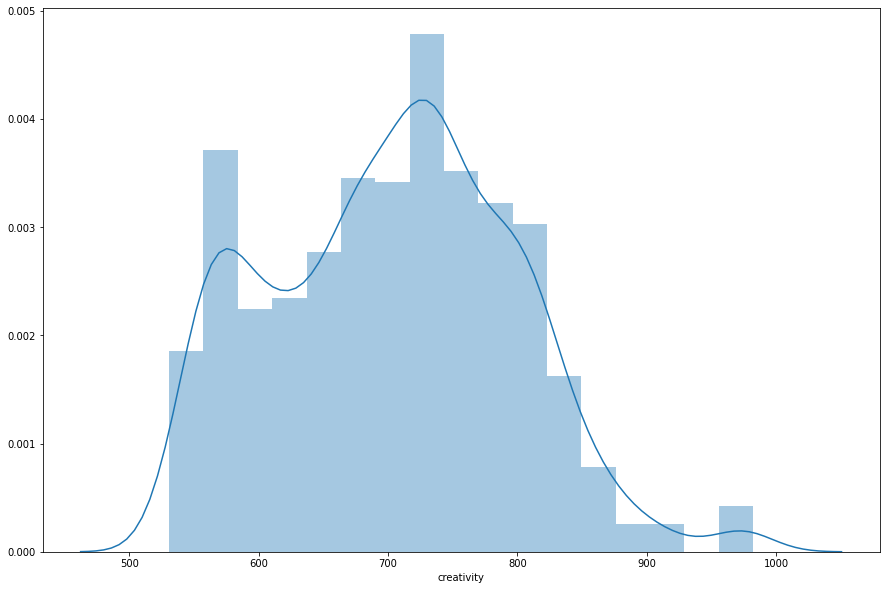

In [230]:
sns.distplot(cluster_games_df.creativity)

In [231]:
cluster_games_df.sort_values('creativity').head(20)

,game_start,game_duration,self_won,self_name,self_race_is_protoss,self_race_is_zerg,self_race_is_terran,opponent_name,opponent_race_is_protoss,opponent_race_is_zerg,...,ToOrbitalCommand_weight,VehicleWeapons1_start,VehicleWeapons1_weight,Viking_start,Viking_weight,WeaponRefit_start,WeaponRefit_weight,WidowMine_start,WidowMine_weight,creativity
a48b1639ce1167a5aaf6e97c0ed25eaec0a2f6f6ed0204a7b5a70208e7527166_0,2020-04-04 11:17:37,472,0.0,DPGCure,0.0,0.0,1.0,INnoVation,0.0,0.0,...,1.418027,1000.0,0.0,17.204651,1.660356,1000.0,0.0,1000.000000,0.0,530.870361
089e7e2f66cf5aa0870ca1584318df59f50865a7ab5a7791e28d0eae9614ab2a_1,2020-03-05 15:22:29,651,0.0,INnoVation,0.0,0.0,1.0,DPGCure,0.0,0.0,...,1.478613,1000.0,0.0,1000.000000,0.000000,1000.0,0.0,1000.000000,0.0,531.749756
9c1535fc9e5a82aae51d01f1224cf404be909187b3876e096fa4e71d78bfee23_1,2020-02-14 20:52:58,702,1.0,liquidthermy,0.0,0.0,1.0,soul,0.0,0.0,...,1.613965,1000.0,0.0,1000.000000,0.000000,1000.0,0.0,1000.000000,0.0,535.265869
2bd67b2db1ed3f5092fbe6d6a181489a758f65fb96081496480014c994136ed0_1,2020-01-02 13:06:22,1007,1.0,DPGCure,0.0,0.0,1.0,Dream,0.0,0.0,...,1.500435,1000.0,0.0,1000.000000,0.000000,1000.0,0.0,1000.000000,0.0,537.226318
4cbdc1c8e3c494a8f0934c28c74cceb0fae5ddb67c171cb67b6652b24fd56bfb_0,2020-04-01 15:50:36,424,0.0,soul,0.0,0.0,1.0,liquidthermy,0.0,0.0,...,1.508740,1000.0,0.0,18.027756,1.000000,1000.0,0.0,1000.000000,0.0,537.659180
8386d7936f8b1e726814b2de37db1fc8519f8980b76eb081bee4ffc96b06ec1a_1,2020-04-05 14:46:59,1009,0.0,LiquidClem,0.0,0.0,1.0,HeroMarine,0.0,0.0,...,1.578654,1000.0,0.0,19.235384,3.649156,1000.0,0.0,1000.000000,0.0,537.776855
fbedeab88cf8ad633830d4fdc216825b4beb5045408dc85416470f19b00b35a0_1,2020-02-24 15:57:01,1212,1.0,Kas,0.0,0.0,1.0,ZipperTheFly,0.0,0.0,...,1.424265,1000.0,0.0,18.973666,1.141256,1000.0,0.0,1000.000000,0.0,538.311523
d0024faa585710db81a5a38d93b7376c9079dddb0e876c69026d19b41c499545_1,2020-04-05 15:05:09,972,1.0,LiquidClem,0.0,0.0,1.0,HeroMarine,0.0,0.0,...,1.405650,1000.0,0.0,1000.000000,0.000000,1000.0,0.0,1000.000000,0.0,538.869629
e6ab4a98c68d27e760dfea4b7d2892ae475dae82db774d080259bc9a9a4bbc25_0,2020-03-06 16:22:53,981,0.0,TSGTYTY,0.0,0.0,1.0,DPGCure,0.0,0.0,...,1.425975,1000.0,0.0,1000.000000,0.000000,1000.0,0.0,1000.000000,0.0,538.975098
7d1431c112f1a93db6a484de7cac3cde1d8c9aaa8cf17a055972d02c8d66562a_1,2020-02-25 16:01:06,887,1.0,uThermal,0.0,0.0,1.0,HolyHit,1.0,0.0,...,1.614641,1000.0,0.0,1000.000000,0.000000,1000.0,0.0,1000.000000,0.0,539.446045


In [232]:
cluster_games_df.sort_values('creativity').tail(20)

,game_start,game_duration,self_won,self_name,self_race_is_protoss,self_race_is_zerg,self_race_is_terran,opponent_name,opponent_race_is_protoss,opponent_race_is_zerg,...,ToOrbitalCommand_weight,VehicleWeapons1_start,VehicleWeapons1_weight,Viking_start,Viking_weight,WeaponRefit_start,WeaponRefit_weight,WidowMine_start,WidowMine_weight,creativity
bfb6e02348a8ff0c40e033356e6af5c141cdaeb481ace690398c6ff0b350bed1_0,2020-03-05 15:51:38,310,1.0,DPGCure,0.0,0.0,1.0,INnoVation,0.0,0.0,...,1.000000,1000.0,0.0,1000.0,0.0,1000.0,0.0,1000.000000,0.000000,906.033447
452859899cfc8ea97f459ce176e2c3fd8c6b45b40a2c9f53c137177c74613c37_0,2020-03-16 13:23:34,568,1.0,TSGTYTY,0.0,0.0,1.0,Astrea,1.0,0.0,...,1.532538,1000.0,0.0,1000.0,0.0,1000.0,0.0,1000.000000,0.000000,906.154053
ff78bd659d6a9b2a7bb4494e775886c275acf9ae6464bd451bbeebefdf763aba_1,2020-03-12 14:28:16,786,0.0,Bunny,0.0,0.0,1.0,Zest,1.0,0.0,...,1.524637,1000.0,0.0,1000.0,0.0,1000.0,0.0,16.062378,3.829451,906.586182
01663bffee84bb4cec0b61d678035282acbd01f59cf6babf32fdfc917b5cd020_0,2020-01-12 15:45:22,806,1.0,Clem,0.0,0.0,1.0,JusticeSimon,1.0,0.0,...,1.539373,1000.0,0.0,1000.0,0.0,1000.0,0.0,15.905974,3.759440,912.037598
5101909981a61a6e71d5d0e723553c7b20067f00dee572496c74527d990dfaac_0,2020-04-09 13:33:24,839,0.0,Dream,0.0,0.0,1.0,Zest,1.0,0.0,...,1.547424,1000.0,0.0,1000.0,0.0,1000.0,0.0,16.401219,3.049584,917.115723
78b41bc733e3e98f957964cadcd2088d54fe16f9323db86fac15201533334c12_0,2020-02-28 11:23:36,619,0.0,Maru,0.0,0.0,1.0,Trap,1.0,0.0,...,1.559031,1000.0,0.0,1000.0,0.0,1000.0,0.0,1000.000000,0.000000,918.026367
9f8f87318569a42d075648a2248f3f0189e7baef5e7bd47fe735404895d5a3bb_0,2020-02-25 16:00:12,812,0.0,Kelazhur,0.0,0.0,1.0,Dear,1.0,0.0,...,1.504499,1000.0,0.0,1000.0,0.0,1000.0,0.0,1000.000000,0.000000,924.809082
cc53fb777abf617fb97997a44877d5e93c7aac997808f9f095a42be3b7286cd0_0,2020-04-16 11:48:22,329,0.0,Dream,0.0,0.0,1.0,TIME,0.0,0.0,...,1.000000,1000.0,0.0,1000.0,0.0,1000.0,0.0,1000.000000,0.000000,960.876221
9ee5cdef6d0696c03f11573d31077e324e6a726759f7f9f1f9bd09cf0aad56ea_1,2020-01-12 15:21:56,391,1.0,Moja,0.0,0.0,1.0,SortOf,0.0,1.0,...,1.622725,1000.0,0.0,1000.0,0.0,1000.0,0.0,1000.000000,0.000000,964.094482
247ecaf32031307f8a22b62dbeecd5db065ae7889c8a086981a9ea2b11583fcd_0,2020-01-03 11:34:02,357,1.0,Moja,0.0,0.0,1.0,Impact,0.0,1.0,...,1.615572,1000.0,0.0,1000.0,0.0,1000.0,0.0,1000.000000,0.000000,964.094482
